<font color = "#CC3D3D"><p>
# Transaction Data based Clustering

- **군집분석이란?**
  - 주어진 데이터를 특성(feature)에 따라 유사한 것끼리 여러 그룹(군집)으로 나누어 각각의 유형별 차이점 분석하는 기법
  - 군집의 개수, 내용, 구조가 파악되지 않은 상태에서 특징을 파악하며, 군집들 간의 관계를 분석 (탐색적 분석)
  - 고객의 세분화 또는 군집 별로 추가적인 분석을 수행하기 위해 활용
- **활용 예시**
  - 고객들을 군집화하여 VIP 고객군과 일반 고객군 간에 어떤 차이점이 있는지 파악
  - 일반 고객들 중에서 VIP 고객 그룹에 더 가까운 고객을 대상으로 교차판매 마케팅 전략을 전개할 수 있음
  - 전체 매장 또는 가맹점 가운데 유사한 성향을 보이는 매장끼리 군집화하여 차별화된 관리 가능
- **군집분석의 평가**
  - 군집의 설명 가능성
  - 군집의 분리
  - 군집의 안정성
- **대표적인 알고리즘**
  - K-means
  - DBSCAN
  - Gaussian Mixture Mode

■ **군집분석을 이용한 고객세분화**  
<img align='left' src='http://drive.google.com/uc?export=view&id=1jJEG8g3kqjQvb2vKHFw9qCY0vxKh2NWL' width=800 height=600>

<img align='left' src="https://t1.daumcdn.net/cfile/tistory/22446C4E57FE2FC611" width=700 height=500>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc  # garbage collection
from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산

pd.set_option('max_columns', 20, 'max_rows', 20)

In [2]:
#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False) 

In [7]:
cs = pd.read_csv('L사_고객정보.csv')
gd = pd.read_csv('L사_상품정보.csv')

In [9]:
cs.head()

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


In [8]:
f = pd.merge(cs,gd, on = 'clnt_id', how = 'left')
f

KeyError: 'clnt_id'

### Data Collection
*출처 : 롯데멤버스, L.pay|L.POINT, 제6회 L.POINT Big Data Competition*

In [3]:
cs = pd.read_csv('L사_고객정보.csv')
# 극단적으로 구매액이 높은 고객이 있어 분석에서 제외.
cs = cs.drop(50578)

gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')

gd.pd_c = gd.pd_c.astype(str).str.zfill(4) # 상품과 거래 데이터의 pd_c 컬럼의 데이터 유형이 서로 달라 맞춰줌. 자리수까지도 맞춰줘야 함. 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문

# 필요없는 데이터 삭제 & 가비지 컬렉션 통한 메모리 관리
del gd, tr
gc.collect()

df

# 업종단위 (biz_unit): 온라인 업종 (A01 / A02 / A03), 오프라인 업종 (B01 / B02 / B03)

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582030,53632,75835,1,A01,0258,2019-08-14,10:00,77040,2,M,50,Computers,Computer Accessories,Printer Inks / Toners
582031,1499,92574,4,A01,1303,2019-09-04,08:09,29000,1,F,50,Sport Fashion,Women's Climbing Clothing,Women's Climbing Vests
582032,58443,103525,1,A01,0263,2019-09-18,10:30,568000,1,F,30,Computers,Computers / Laptops,Tablet PCs
582033,21232,103476,1,A01,0263,2019-09-18,01:38,362500,1,F,30,Computers,Computers / Laptops,Tablet PCs


### Data Cleansing

In [4]:
# 구매금액이나 구매건수 컬럼이 잘못되어 있는 비율
print(df.query('buy_am == 0 or  buy_ct == 0').shape[0])

# case-1
print(df.query('buy_am != 0 and buy_ct == 0').shape[0])
# case-2
print(df.query('buy_am == 0 and buy_ct != 0').shape[0])
# case-3
print(df.query('buy_am == 0 and buy_ct == 0').shape[0])

6770
6244
83
443


In [5]:
# 해결책
# case-1 : buy_ct를 1로 설정 
df['buy_ct'] = np.where(df.buy_ct == 0, 1, df.buy_ct)
# case-2, case-3: 해당 레코드 삭제
df = df.query('buy_am != 0')

In [6]:
# 데이터 요약
print('=======  분석 데이터 요약  =======')
print('▶ 고객수:', df.clnt_id.nunique())
print(f'▶ 상품수: 대분류({df.clac_nm1.nunique()}), 중분류({df.clac_nm2.nunique()}), 소분류({df.clac_nm3.nunique()})')
print('▶ 업종수:', df.biz_unit.nunique())
print(f'▶ 기간: {df.de_dt.min()} ~ {df.de_dt.max()} ({(df.de_dt.max()-df.de_dt.min()).days+1}일)')

=======  분석 데이터 요약  =======
▶ 고객수: 11265
▶ 상품수: 대분류(59), 중분류(331), 소분류(1655)
▶ 업종수: 6
▶ 기간: 2019-07-01 00:00:00 ~ 2019-09-30 00:00:00 (92일)


### Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [7]:
features = pd.DataFrame({'clnt_id': df.clnt_id.unique()})
features

,clnt_id
0,21922
1,39423
2,18362
3,48969
4,18478
...,...
11260,15146
11261,53632
11262,58443
11263,21232


**[Feature 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [8]:
f = df.groupby('clnt_id')['buy_am'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액
0,21922,79980,13,6152,13900
1,39423,676262,134,5047,55600
2,18362,802720,117,6861,55600
3,48969,388898,100,3889,25800
4,18478,1998300,32,62447,711000
...,...,...,...,...,...
11260,15146,52800,1,52800,52800
11261,53632,77040,1,77040,77040
11262,58443,568000,1,568000,568000
11263,21232,362500,1,362500,362500


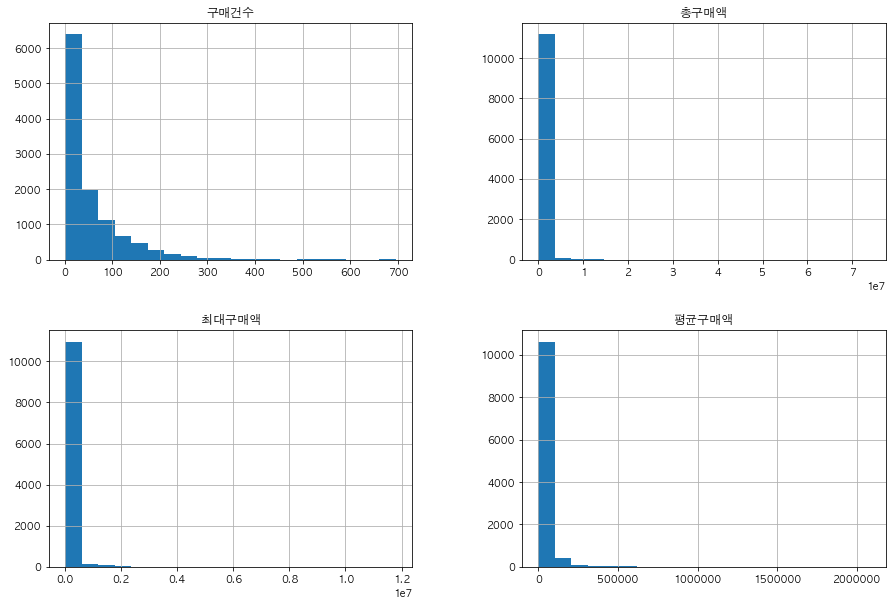

In [9]:
# histogram
f.iloc[:,1:].hist(bins=20, figsize=(15,10))
plt.show()

**[Feature 5-7]** 구매상품수(대/중/소분류 각각)

In [10]:
# multi index -> single index
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [11]:
f = df.groupby('clnt_id').agg({
    'clac_nm3': [('구매상품수(소)', lambda x: x.nunique())],
    'clac_nm2': [('구매상품수(중)', lambda x: x.nunique())],
    'clac_nm1': [('구매상품수(대)', lambda x: x.nunique())]
}).reset_index()
f

,clnt_id,clac_nm3,clac_nm2,clac_nm1
,,구매상품수(소),구매상품수(중),구매상품수(대)
0,2,8,7,7
1,9,34,26,14
2,12,1,1,1
3,20,30,21,12
4,23,40,32,13
...,...,...,...,...
11260,72373,18,17,14
11261,72400,4,4,3
11262,72410,31,25,17


In [12]:
f.columns = drop_column_level(f)
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대)
0,21922,79980,13,6152,13900,12,9,7
1,39423,676262,134,5047,55600,62,43,20
2,18362,802720,117,6861,55600,60,38,18
3,48969,388898,100,3889,25800,65,43,17
4,18478,1998300,32,62447,711000,21,16,13
...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1
11261,53632,77040,1,77040,77040,1,1,1
11262,58443,568000,1,568000,568000,1,1,1
11263,21232,362500,1,362500,362500,1,1,1


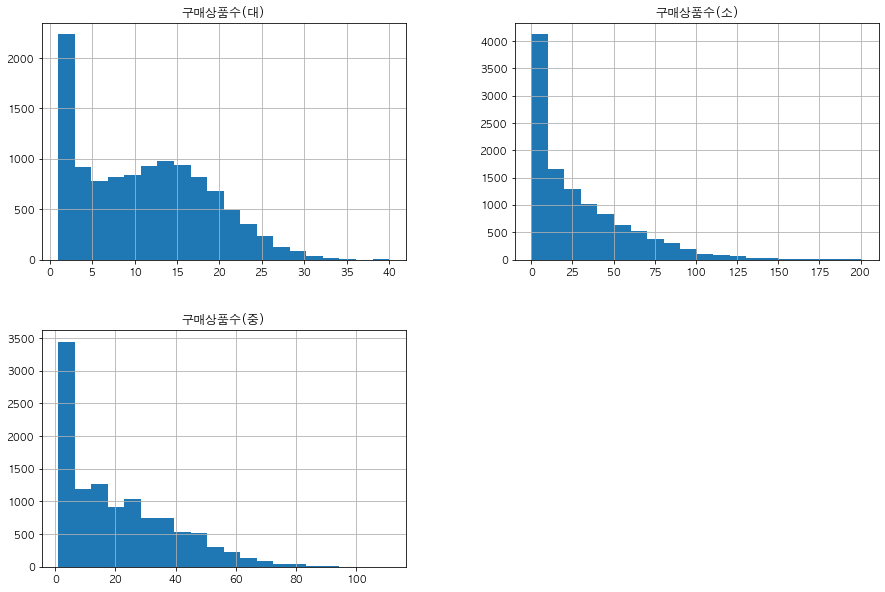

In [13]:
# histogram
f.iloc[:,1:].hist(bins=20, figsize=(15,10))
plt.show()

**[Feature 8-10]** 내점일수, 구매주기, 주말방문율

In [14]:
f = df.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03
...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00


/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


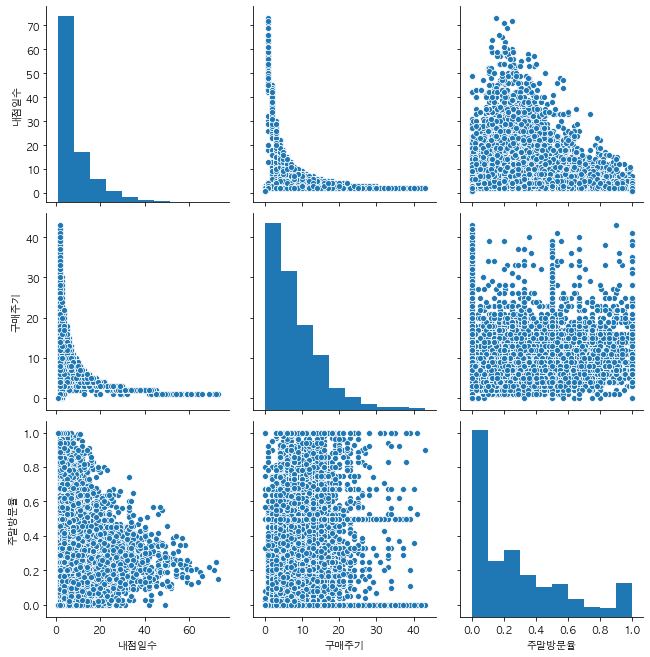

In [15]:
sns.pairplot(data=f.iloc[:,1:], size=3)
plt.show()

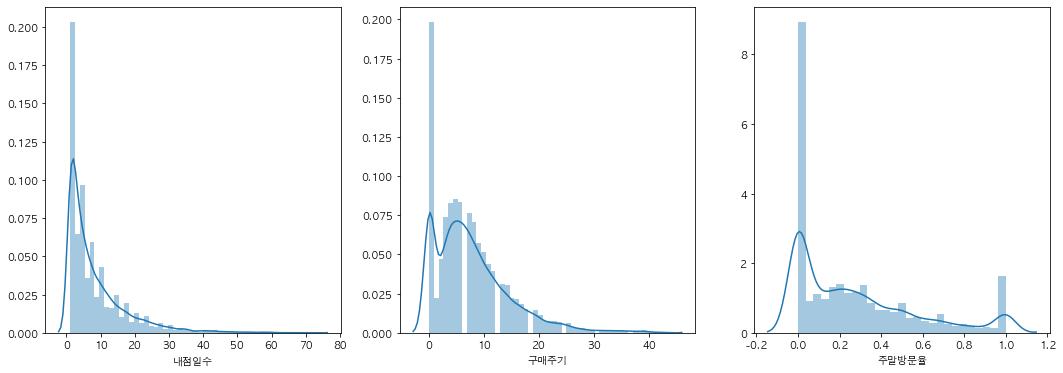

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.distplot(f.내점일수, ax=ax[0])
sns.distplot(f.구매주기, ax=ax[1])
sns.distplot(f.주말방문율, ax=ax[2])
plt.show()

**[Feature 11-12]** 거래 당 평균 구매액, 구매건수

In [17]:
visit_cnt = df.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
per_amount = (df.groupby('clnt_id')['buy_am'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (df.groupby('clnt_id')['buy_am'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})
f = pd.merge(per_amount, per_count, on='clnt_id')
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0


**[Feature 13]** 구매추세 패턴

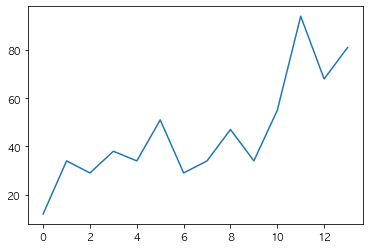

In [18]:
# 데이터로부터 추세선을 찾는 방법
data = [12, 34, 29, 38, 34, 51, 29, 34, 47, 34, 55, 94, 68, 81]
plt.plot(data)
plt.show()

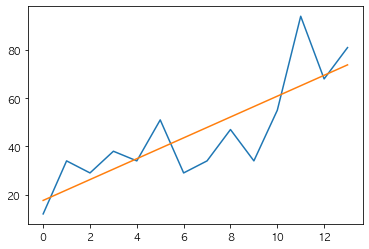

In [19]:
# numpy의 ployfit 사용
x = np.arange(len(data))
y = np.array(data)
z = np.polyfit(x, y, 1)
z[0], z[1]

plt.plot(data)
plt.plot([z[0]*i + z[1] for i in range(len(data))])
plt.show()

In [20]:
# 마지막주부터 10주전까지 (총 10주 간) 매주 구매건수를 계산하여 리스트에 넣음
week_to = df.de_dt.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < de_dt <= @week_to')
                      .groupby('clnt_id')['trans_id']
                      .agg([(f'w{10-i}', 'count')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'clnt_id': df.clnt_id.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)

# 각 고객별로 10주간 구매에 대한 추세선(ax+b)을 계산하여 기울기(a)를 해당 고객의 추세패턴으로 사용 
# 기울기가 양수면 시간이 지나면서 구매가 증가한다는 뜻. 음수면 반대.
f['구매추세'] = f.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04


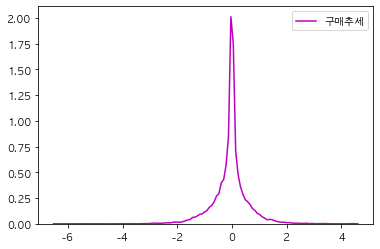

In [21]:
sns.kdeplot(f.구매추세, color='m')
plt.show()

**[Feature 14]** 주구매시간

In [22]:
f = df.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1


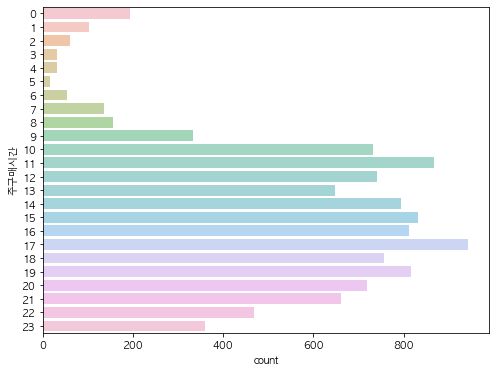

In [23]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y='주구매시간', data=f, alpha=0.5)  

**[Feature 15]** 가격선호도 (고가상품구매율)

In [24]:
# 판매단가 계산
df['price'] = df['buy_am'] / df['buy_ct']

# 상품별 평균 판매단가에 대한 4분위수 계산 => 3Q 이상을 고가상품으로 설정
price_4q = df.groupby('pd_c')['price'].mean().quantile([.25,.5,.75])
price_4q

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.25     4524.444444
0.50     9162.007797
0.75    25777.266788
Name: price, dtype: float64

In [25]:
f = (df.groupby('clnt_id')['price']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.01
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10,0.00
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10,0.00
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10,1.00
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,1.00
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.00
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.00


### Feature Selection

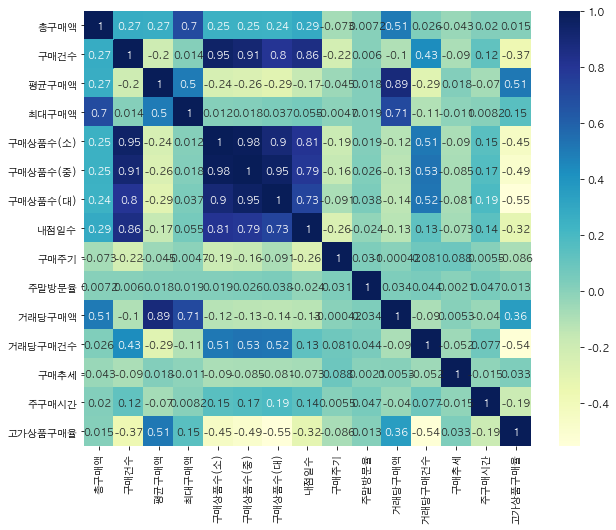

In [26]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

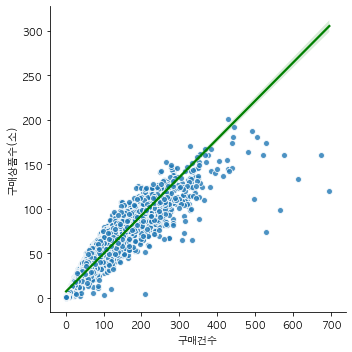

In [27]:
# 양의 상관관계가 매우 높음.
sns.lmplot(x='구매건수', y='구매상품수(소)', data=features, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show()

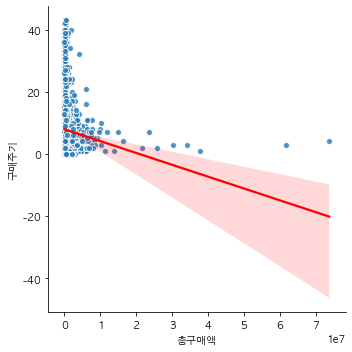

In [28]:
# 음의 상관관계가 있으나 유의하지 않음.
sns.lmplot(x='총구매액', y='구매주기', data=features, 
           line_kws={'color':"red"}, scatter_kws={'edgecolor':"white"})
plt.show()

In [29]:
# 상관관계가 높은 (서로 유사한) feature를 제거
features = features.drop(columns=['구매건수', '구매상품수(소)', '구매상품수(대)', '거래당구매액'])
features

,clnt_id,총구매액,평균구매액,최대구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,21922,79980,6152,13900,9,5,16,0.00,2.2,0.27,21,0.00
1,39423,676262,5047,55600,43,19,4,0.09,5.8,0.32,15,0.01
2,18362,802720,6861,55600,38,20,4,0.00,5.3,0.22,10,0.00
3,48969,388898,3889,25800,43,10,8,0.00,8.3,0.16,10,0.00
4,18478,1998300,62447,711000,16,12,6,0.03,1.9,-0.27,10,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,52800,52800,1,1,0,0.00,1.0,-0.04,10,1.00
11261,53632,77040,77040,77040,1,1,0,0.00,1.0,-0.02,10,1.00
11262,58443,568000,568000,568000,1,1,0,0.00,1.0,0.04,10,1.00
11263,21232,362500,362500,362500,1,1,0,0.00,1.0,0.04,1,1.00


In [30]:
features.to_csv('features.csv', index=False, encoding='cp949')

In [31]:
# Pandas Profiling To Boost Exploratory Data Analysis
# - Install: !pip install pandas-profiling
# - Usage:
# import pandas_profiling as pp
# pp.ProfileReport(data)

### Cluster Analysis

*데이터 표준화(또는 정규화)*

In [32]:
X = features.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) #정규화
X

,총구매액,평균구매액,최대구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,2.964419,-0.123237,0.200802,-0.380151,-0.380318,-0.379858,-0.380528,-0.380436,-0.380516,-0.379649,-0.380528
1,3.005019,-0.305564,-0.056226,-0.330245,-0.330364,-0.330438,-0.330457,-0.330429,-0.330456,-0.330383,-0.330457
2,3.007957,-0.298273,-0.095797,-0.326618,-0.326693,-0.326759,-0.326776,-0.326754,-0.326775,-0.326734,-0.326776
3,3.008542,-0.293032,-0.105138,-0.326013,-0.326296,-0.326313,-0.326382,-0.326310,-0.326380,-0.326296,-0.326382
4,2.831345,-0.307296,0.744217,-0.408517,-0.408523,-0.408533,-0.408543,-0.408539,-0.408543,-0.408526,-0.408542
...,...,...,...,...,...,...,...,...,...,...,...
11260,1.556998,1.556998,1.556998,-0.583904,-0.583904,-0.583945,-0.583945,-0.583904,-0.583947,-0.583539,-0.583904
11261,1.556998,1.556998,1.556998,-0.583895,-0.583895,-0.583923,-0.583923,-0.583895,-0.583923,-0.583645,-0.583895
11262,1.556998,1.556998,1.556998,-0.583877,-0.583877,-0.583881,-0.583881,-0.583877,-0.583881,-0.583843,-0.583877
11263,1.556998,1.556998,1.556998,-0.583872,-0.583872,-0.583878,-0.583878,-0.583872,-0.583878,-0.583872,-0.583872


In [33]:
KMeans(n_clusters = 4, random_state = 0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

*최적 군집 수(K) 도출: Elbow method + Silhouette method*

<img align='left' src='http://drive.google.com/uc?export=view&id=1tTJ5HF0eXqjdz5mXMRg0wRKPx27D3mUX' width=500 height=400>

In [34]:
# 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산

wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

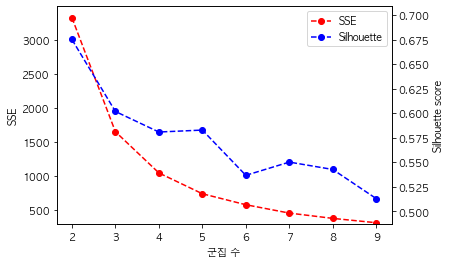

In [35]:
# 군집 수에 따른 SSE와 Silhouette score 시각화
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

In [36]:
# Yellowbrick은 machine learning visualization 패키지 중 하나
# !pip install yellowbrick

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


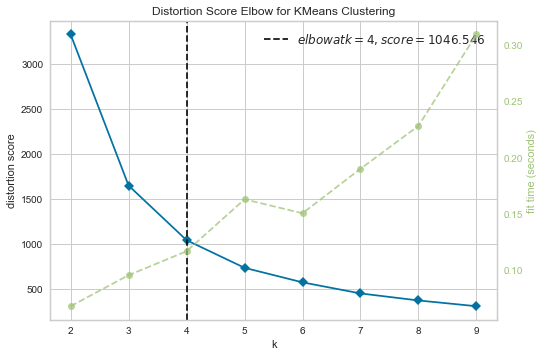

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3e88d0150>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [37]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

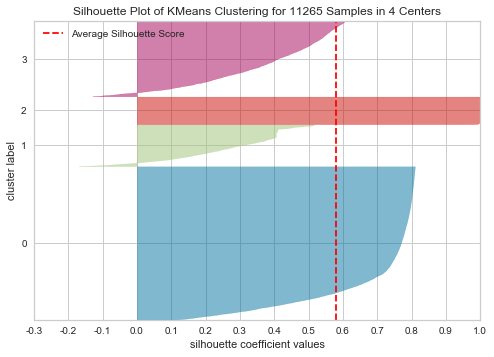

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3e65e0450>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [38]:
# Silhouette diagram
# 높이: 군집의 크기, 넓이: 각 군집에 포함된 샘플의 정렬된 실루엣 계수, 점선: 실루엣 점수  
# 각 군집의 샘플 대부분이 실루엣 점수를 초과하면 군집의 수가 적당한 것으로 판단

from yellowbrick.cluster import silhouette_visualizer

silhouette_visualizer(KMeans(4, random_state=0), X, colors='yellowbrick')

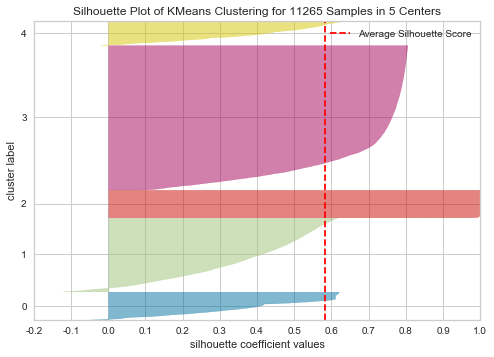

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3e6690c10>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [39]:
silhouette_visualizer(KMeans(5, random_state=0), X, colors='yellowbrick')

In [40]:
# sns 설정이 바뀌었기 때문에 원래로 되돌린다.
sns.reset_defaults()
%matplotlib inline

# Yellowbrick은 영문 폰트를 사용하여 시각화를 하기 떄문에 다시 한글 폰트로 변경해야 한다.
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

In [41]:
best_k = 5

*군집분석을 통한 고객 세분화*

In [42]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [43]:
features['세그먼트'] = kmeans.labels_
features
#어디에 속한 군집인지를 확인함.

,clnt_id,총구매액,평균구매액,최대구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율,세그먼트
0,21922,79980,6152,13900,9,5,16,0.00,2.2,0.27,21,0.00,3
1,39423,676262,5047,55600,43,19,4,0.09,5.8,0.32,15,0.01,3
2,18362,802720,6861,55600,38,20,4,0.00,5.3,0.22,10,0.00,3
3,48969,388898,3889,25800,43,10,8,0.00,8.3,0.16,10,0.00,3
4,18478,1998300,62447,711000,16,12,6,0.03,1.9,-0.27,10,0.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,52800,52800,1,1,0,0.00,1.0,-0.04,10,1.00,2
11261,53632,77040,77040,77040,1,1,0,0.00,1.0,-0.02,10,1.00,2
11262,58443,568000,568000,568000,1,1,0,0.00,1.0,0.04,10,1.00,2
11263,21232,362500,362500,362500,1,1,0,0.00,1.0,0.04,1,1.00,2


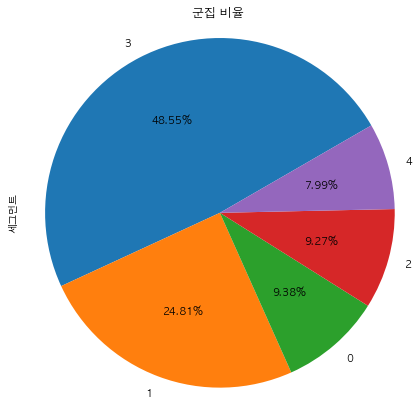

In [44]:
plt.figure(figsize=(6,6))
features.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

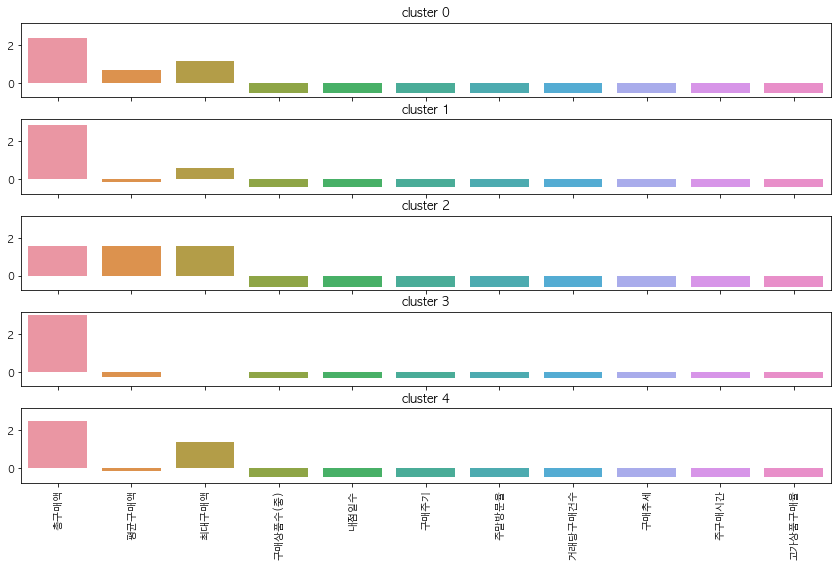

In [45]:
fig, ax = plt.subplots(best_k, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() # 자동으로 레이아웃 조정
#plt.subplots_adjust(hspace=0.2) # subplot간의 너비 간격 조절

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
#    ax[i].bar(np.arange(X.columns.size), kmeans.cluster_centers_[i])
    sns.barplot(np.arange(X.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)
    

    
#한눈에 어떤 군집의 특성을 알 수있음.
# 군집 4의 최대 구매액이 매우 작아 보임.

<font color = "#CC3D3D"><p>
# End